In [37]:
import random
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import MONGO_URL, END_DATE
from scripts.analysis import data, plot

from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

plot.init_matplotlib()

W, H = 6, 2.5

In [38]:
repos, stars = data.get_fake_star_repos(), data.get_fake_stars_by_month()
repos_with_campaign = data.get_repos_with_campaign()
repo_events = data.get_events_with_samples("repo")
actor_events = data.get_events_with_samples("actor")
repo_events.event = repo_events.event.apply(plot.shorten_gharchive_event)
actor_events.event = actor_events.event.apply(plot.shorten_gharchive_event)
repo_events = (
    repo_events.groupby(["repo", "event", "group"])["percentage"].sum().reset_index()
)
actor_events = (
    actor_events.groupby(["actor", "event", "group"])["percentage"].sum().reset_index()
)

In [39]:
# bean counting
print("# repos with suspected fake stars:", len(repos))
print(
    "# suspected fake stars:",
    sum(stars.n_stars_fake),
    ", # low activity, ",
    sum(stars.n_stars_low_activity),
    ", # clustered, ",
    sum(stars.n_stars_clustered),
)
print("# repos with suspected fake star campaigns:", len(repos_with_campaign))
print(
    "# suspected fake stars in those campaigns:",
    sum(stars[stars.repo.isin(repos_with_campaign)].n_stars_fake),
)

low_activity_actors = data.get_unique_actors(
    "low_activity_stars", {"low_activity": True}
)
clustered_actors = data.get_unique_actors("clustered_stars", {"clustered": True})
print(
    "# actors in suspected fake stars:",
    len(clustered_actors | low_activity_actors),
)

low_activity_actors_in_campaign = data.get_unique_actors(
    "low_activity_stars",
    {"low_activity": True, "repo": {"$in": list(repos_with_campaign)}},
)
clustered_actors_in_campaign = data.get_unique_actors(
    "clustered_stars",
    {"clustered": True, "repo": {"$in": list(repos_with_campaign)}},
)
print(
    "# actors in suspected fake star campaigns:",
    len(clustered_actors_in_campaign | low_activity_actors_in_campaign),
)

# repos with suspected fake stars: 22915
# suspected fake stars: 4525461.0 , # low activity,  946858.0 , # clustered,  3578603.0
# repos with suspected fake star campaigns: 15835
# suspected fake stars in those campaigns: 3076427.0
# actors in suspected fake stars: 1070551
# actors in suspected fake star campaigns: 201873


In [40]:
# How many random sample repos and actors are already polluted?
sample_repo_events = pd.read_csv(f"data/{END_DATE}/sample_repo_events.csv")
sample_actor_events = pd.read_csv(f"data/{END_DATE}/sample_actor_events.csv")
print(
    f"# polluted repos in sample_repo_events: "
    f"{len(set(sample_repo_events.repo) & set(repos.repo_name))} "
    f"out of {len(sample_repo_events.repo)}",
)
print(
    f"# polluted actors in sample_actor_events: "
    f"{len(set(sample_actor_events.actor) & (clustered_actors | low_activity_actors))} "
    f"out of {len(sample_actor_events.actor)}",
)
print(
    f"After filtering: "
    f"{repo_events[repo_events.group == "Samples"].repo.nunique()} sample repos, "
    f"{actor_events[actor_events.group == "Samples"].actor.nunique()} sample actors"
)

# polluted repos in sample_repo_events: 386 out of 10000
# polluted actors in sample_actor_events: 366 out of 10000
After filtering: 9614 sample repos, 9634 sample actors


In [41]:
# face validity check: how many of the repos and actors are deleted?
deleted = repos.repo_id.isnull()
low_act = repos.n_stars_low_activity > 0
clustered = repos.n_stars_clustered > 0
campaign = repos.repo_name.isin(repos_with_campaign)
sample_repo_ids = pd.read_csv(f"data/{END_DATE}/sample_repo_ids.csv")
print(
    f"Baseline % deletion: {len(sample_repo_ids[sample_repo_ids.id.isnull()]) / len(repos) * 100:.2f}%"
)
print(
    f"% deleted in repos with fake stars: {len(repos[deleted]) / len(repos) * 100:.2f}\n"
    f"% deleted in low activity repos: {len(repos[deleted & low_act]) / len(repos[low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos: {len(repos[deleted & clustered]) / len(repos[clustered]) * 100:.2f}\n"
)
print(
    f"% deleted in repos with fake star campaigns: {len(repos[deleted & campaign]) / len(repos[campaign]) * 100:.2f}\n"
    f"% deleted in low activity repos with campaign: {len(repos[deleted & campaign & low_act]) / len(repos[campaign & low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos with campaign: {len(repos[deleted & campaign & clustered]) / len(repos[campaign & clustered]) * 100:.2f}\n"
)

fake_user_info = pd.read_csv(f"data/{END_DATE}/fake_user_info.csv")
sample_user_info = pd.read_csv(f"data/{END_DATE}/sample_user_info.csv")

deleted = fake_user_info.error.notnull()
low_act = fake_user_info.actor.isin(low_activity_actors) | fake_user_info.login.isin(
    low_activity_actors
)
clustered = fake_user_info.actor.isin(clustered_actors) | fake_user_info.login.isin(
    clustered_actors
)
campaign = fake_user_info.actor.isin(
    clustered_actors_in_campaign | low_activity_actors_in_campaign
) | fake_user_info.login.isin(
    clustered_actors_in_campaign | low_activity_actors_in_campaign
)
print(
    f"Baseline % deletion: {len(sample_user_info[sample_user_info.error.notnull()]) / len(repos) * 100:.2f}%"
)
print(
    f"% deleted in repos with fake stars: {len(fake_user_info[deleted]) / len(fake_user_info) * 100:.2f}\n"
    f"% deleted in low activity repos: {len(fake_user_info[deleted & low_act]) / len(fake_user_info[low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos: {len(fake_user_info[deleted & clustered]) / len(fake_user_info[clustered]) * 100:.2f}\n"
)
print(
    f"% deleted in repos with fake star campaigns: {len(fake_user_info[deleted & campaign]) / len(fake_user_info[campaign]) * 100:.2f}\n"
    f"% deleted in low activity repos with campaign: {len(fake_user_info[deleted & campaign & low_act]) / len(fake_user_info[campaign & low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos with campaign: {len(fake_user_info[deleted & campaign & clustered]) / len(fake_user_info[campaign & clustered]) * 100:.2f}\n"
)

Baseline % deletion: 5.84%
% deleted in repos with fake stars: 69.17
% deleted in low activity repos: 13.62
% deleted in clustered repos: 81.51

% deleted in repos with fake star campaigns: 90.75
% deleted in low activity repos with campaign: 79.91
% deleted in clustered repos with campaign: 91.03

Baseline % deletion: 4.43%
% deleted in repos with fake stars: 18.59
% deleted in low activity repos: 19.83
% deleted in clustered repos: 33.70

% deleted in repos with fake star campaigns: 61.95
% deleted in low activity repos with campaign: 71.81
% deleted in clustered repos with campaign: 45.02



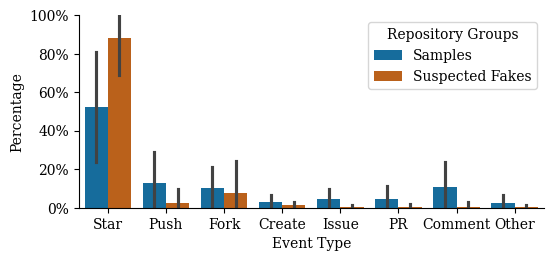

In [42]:
fig, ax = plt.subplots(figsize=(W, H))
sns.barplot(
    x="event",
    y="percentage",
    data=repo_events[
        repo_events.repo.isin(repos_with_campaign) | (repo_events.group == "Samples")
    ],
    hue="group",
    hue_order=["Samples", "Suspected Fakes"],
    order=plot.EVENT_ORDER,
    palette=["C0", "C2"],
    errorbar="sd",
    ax=ax,
)
ax.set_ylabel("Percentage")
ax.set_xlabel("Event Type")
ax.legend(title="Repository Groups")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# fig.autofmt_xdate()
fig.savefig("plots/repo-events.pdf", bbox_inches="tight", dpi=300)

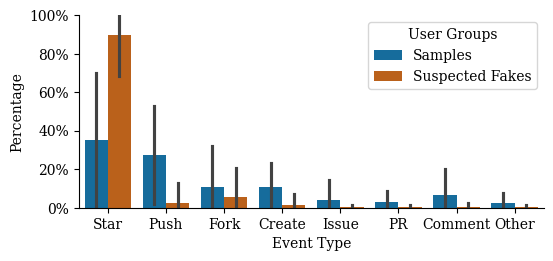

In [43]:
fig, ax = plt.subplots(figsize=(W, H))
sns.barplot(
    x="event",
    y="percentage",
    data=actor_events[
        actor_events.actor.isin(
            clustered_actors_in_campaign | low_activity_actors_in_campaign
        )
        | (actor_events.group == "Samples")
    ],
    hue="group",
    order=plot.EVENT_ORDER,
    hue_order=["Samples", "Suspected Fakes"],
    palette=["C0", "C2"],
    errorbar="sd",
    ax=ax,
)
ax.set_ylabel("Percentage")
ax.set_xlabel("Event Type")
ax.legend(title="User Groups")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# fig.autofmt_xdate()
fig.savefig("plots/actor-events.pdf", bbox_inches="tight", dpi=300)

In [44]:
%%capture
# visual evaluation of post processing
"""
long_lived_repos = set(
    stars.groupby("repo").filter(lambda x: len(x) >= 3).repo.unique()
)
sample = random.sample(list(repos_with_campaign & long_lived_repos), 100)

fig, axes = plt.subplots(20, 5, figsize=(50, 80))
for i, repo in enumerate(sample):
    df = stars[stars["repo"] == repo]
    ax = axes[i // 5, i % 5]
    df.plot(kind="bar", x="month", y="n_stars", ax=ax, color="C0")
    df.plot(kind="bar", x="month", y="n_stars_fake", ax=ax, color="C1")
    ax.set_xticklabels([])
    ax.set_title(repo)
fig.savefig("plots/fake_star_campaigns.pdf")
"""

In [45]:
X_fake_repo = (
    repo_events[
        (repo_events.group == "Suspected Fakes")
        & repo_events.repo.isin(repos_with_campaign)
    ]
    .drop(columns="group")
    .pivot(columns="event", index="repo", values="percentage")
    .reset_index()
)
X_fake_actor = (
    actor_events[
        (actor_events.group == "Suspected Fakes")
        & actor_events.actor.isin(
            clustered_actors_in_campaign | low_activity_actors_in_campaign
        )
    ]
    .drop(columns="group")
    .pivot(columns="event", index="actor", values="percentage")
    .reset_index()
)
X_sample_repo = (
    repo_events[repo_events.group == "Samples"]
    .drop(columns="group")
    .pivot(columns="event", index="repo", values="percentage")
    .reset_index()
)
X_sample_actor = (
    actor_events[actor_events.group == "Samples"]
    .drop(columns="group")
    .pivot(columns="event", index="actor", values="percentage")
    .reset_index()
)

Y_repos, Y_actors = {}, {}
perplexities = [30, 50, 100]
for perplexity in perplexities:
    tSNE = TSNE(n_components=2, perplexity=perplexity, random_state=114514)
    Y_repos[perplexity] = tSNE.fit_transform(
        np.concatenate(
            [
                X_fake_repo.set_index("repo").to_numpy(),
                X_sample_repo.set_index("repo").to_numpy(),
            ]
        )
    )
    Y_actors[perplexity] = tSNE.fit_transform(
        np.concatenate(
            [
                X_fake_actor.set_index("actor").to_numpy(),
                X_sample_actor.set_index("actor").to_numpy(),
            ]
        )
    )

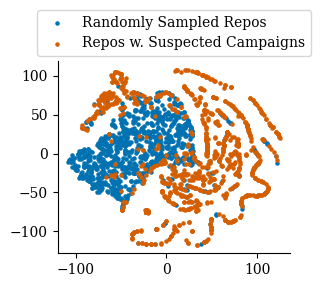

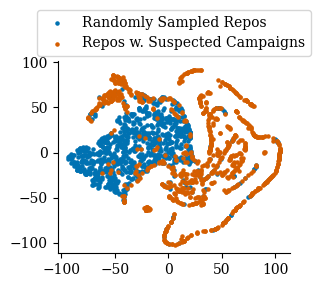

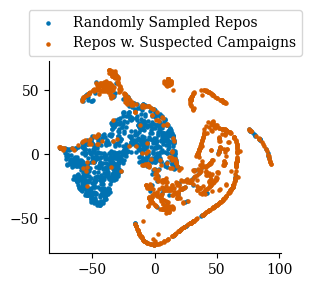

In [57]:
low_activity_ids = list(
    X_fake_actor[X_fake_actor.actor.isin(low_activity_actors)].index
)
clustered_ids = list(X_fake_actor[X_fake_actor.actor.isin(clustered_actors)].index)
sample_fakes = random.sample(range(0, len(X_fake_repo)), 1000)
sample_reals = random.sample(
    range(len(X_fake_repo), len(X_fake_repo) + len(X_sample_repo)), 1000
)

for perplexity in perplexities:
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
    ax.scatter(
        Y_repos[perplexity][sample_reals, 0],
        Y_repos[perplexity][sample_reals, 1],
        c="C0",
        s=5,
        label="Randomly Sampled Repos",
    )
    ax.scatter(
        Y_repos[perplexity][sample_fakes, 0],
        Y_repos[perplexity][sample_fakes, 1],
        c="C2",
        s=5,
        label="Repos w. Suspected Campaigns",
    )
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3)),
    # ax.set_title(f"t-SNE (perplexity={perplexity})")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.savefig(f"plots/tsne-repos-{perplexity}.pdf", bbox_inches="tight", dpi=300)

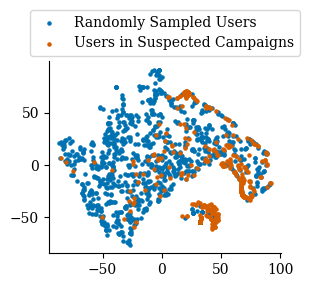

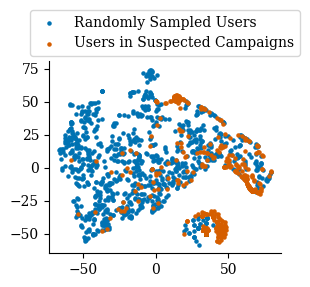

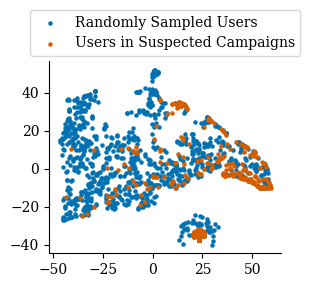

In [62]:
low_activity_ids = list(
    X_fake_actor[X_fake_actor.actor.isin(low_activity_actors)].index
)
clustered_ids = list(X_fake_actor[X_fake_actor.actor.isin(clustered_actors)].index)
sample_fakes = random.sample(range(0, len(X_fake_actor)), 1000)
sample_reals = random.sample(
    range(len(X_fake_actor), len(X_fake_actor) + len(X_sample_actor)), 1000
)

for perplexity in perplexities:
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
    ax.scatter(
        Y_actors[perplexity][sample_reals, 0],
        Y_actors[perplexity][sample_reals, 1],
        c="C0",
        s=5,
        label="Randomly Sampled Users",
    )
    ax.scatter(
        Y_actors[perplexity][sample_fakes, 0],
        Y_actors[perplexity][sample_fakes, 1],
        c="C2",
        s=5,
        label="Users in Suspected Campaigns",
    )
    """
    ax.scatter(
        Y_actors[perplexity][low_activity_ids, 0],
        Y_actors[perplexity][low_activity_ids, 1],
        c="C2",
        s=5,
        alpha=1.0,
        # edgecolors="black",
        label="Stargazers with the Low Activity Heusristic",
    )
    ax.scatter(
        Y_actors[perplexity][clustered_ids, 0],
        Y_actors[perplexity][clustered_ids, 1],
        c="C3",
        s=5,
        alpha=1.0,
        # edgecolors="black",
        label="Stargazers with the Clustering Heusristic",
    )"""
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))
    #ax.set_title(f"t-SNE (perplexity={perplexity})")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.savefig(f"plots/tsne-actors-{perplexity}.pdf", bbox_inches="tight", dpi=300)